### Some numerical differentiation for irregular domains embedded in a regular grid

In [1]:
# in my own setting, this is pre-imported
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def right_2Ddomain(M):
    """
    M is a 2D binary mask. I return a new mask
    Mr = {(i+1,j) in M, such that (i,j) in M}
    """
    m, n = M.shape
    Mr = np.zeros_like(M, dtype=bool)
    Md = np.zeros_like(M, dtype=bool)
    X, Y = np.where(M)
    for i, j in zip(X, Y):
        if M[i, j]:
            if i + 1 < m and M[i + 1, j] :
                 Mr[i ,j] = True
            if j + 1 < n and M[i, j + 1]:
                Md[i, j] = True
    return Mr, Md, X, Y


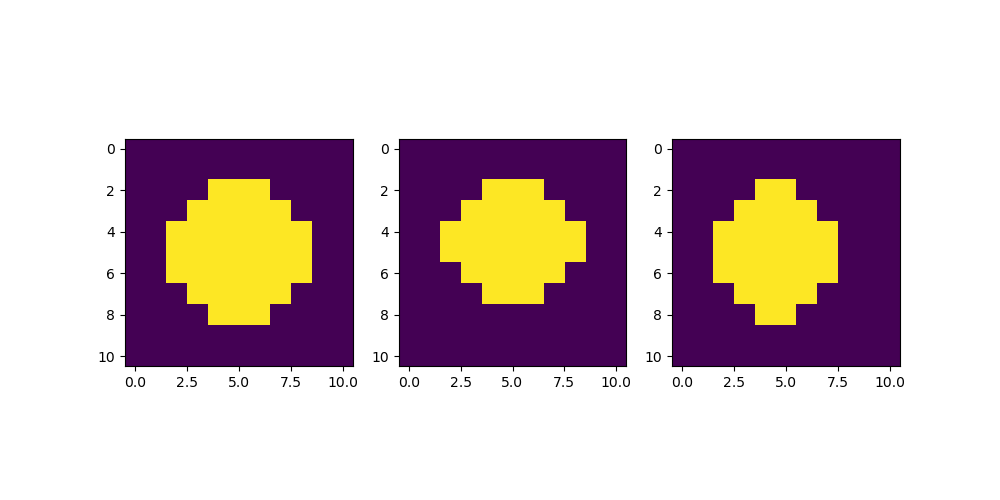

In [3]:
x, y = np.mgrid[-1:1:11*1j, -1:1:11*1j]
M = x**2 + y**2 < 0.5
Mr, Md, _, _ = right_2Ddomain(M)
_, (ax, axr, axd) = plt.subplots(1, 3)
ax.imshow(M)
axr.imshow(Mr)
axd.imshow(Md)
plt.show()


In [4]:
def gradient(x, M, Mr, Md, X, Y):
    """Irregular 2D gradient."""
    Dx = np.zeros(x.shape + (2,))
    for i, j in zip(X, Y):
        if Mr[i, j]: Dx[i, j, 0] = x[i + 1, j] - x[i, j]
        if Md[i, j]: Dx[i, j, 1] = x[i, j + 1] - x[i, j]
    return Dx

In [5]:
cam = data.camera().astype(float)
m, n = cam.shape
x, y = np.mgrid[-1:1:m*1j, -1:1:n*1j]
M = x**2 + y**2 < 0.5
Mr, Md, X, Y = right_2Ddomain(M)
Dx = gradient(cam, M, Mr, Md, X, Y)

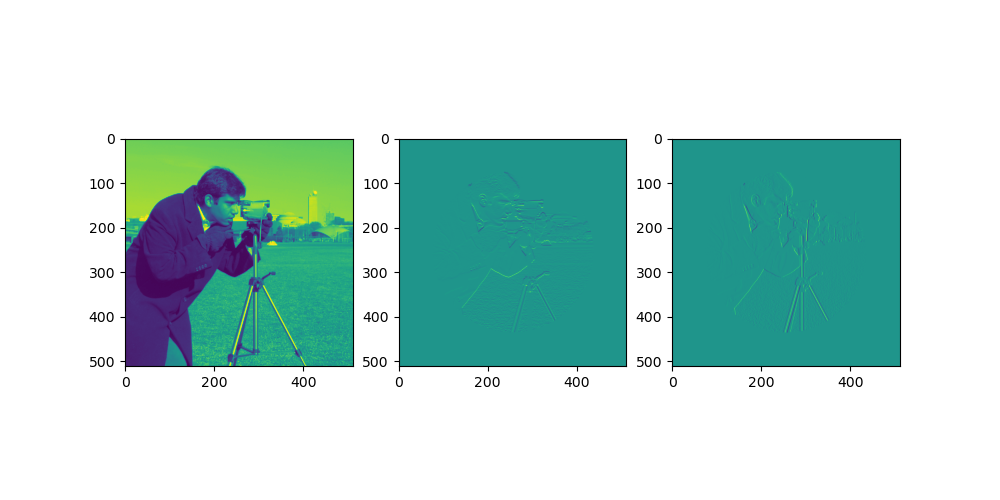

In [6]:
_, (ax, axx, axy) = plt.subplots(1,3)
ax.imshow(cam)
axx.imshow(Dx[:,:,0])
axy.imshow(Dx[:,:,1])

In [9]:
def stencil2D(M):
    m, n = M.shape
    X, Y = np.where(M)
    l = len(X)
    F = -np.ones_like(M)
    # F[x, y] = -1 if x, y 
    F[X, Y] = range(l)
    
    S = np.zeros((l, 8))
    #order is W, N, E, W
    #
    for i in range(l):
        x, y = X[i], Y[i]
        if x > 0 and M[x - 1, y]: # West
            S[i,0] = 1
        if x < m - 1 and M[x + 1, y]: # East
            S[i, 2] = 1
        if y < n - 1 and M[x, y + 1]: # North
            S[i, 1] = 1;
        if y > 0 and M[x, y - 1]: # South
            S[i, 3] = 1;
    stencil = {'X' : X, 'Y': Y, 'S' : S, 'F' : F}
    return stencil


def stencil_gradient_from_2D(f, stencil):
    west, north, east, south = 0, 1, 2, 3
    df = np.zeros(l, 2)
    X = stencil['X']
    Y = stencil['Y']
    S = stencil['S']
    l = len(S)
    for i, x, y in enumerate(zip(X, Y)):
        if S[i, east] != 0:
            df[i, 0] = f[x + 1, y] - f[x, y]
        if S[i, north] != 0:
            df[i, 1] = f[x, y + 1] - f[x, y]
    return df


def stencil_gradient_from_flattened(f, stencil):
    west, north, east, south = 0, 1, 2, 3
    X = stencil['X']
    Y = stencil['Y']
    S = stencil['S']
    l = len(S)
    F = stencil['F']
    df = np.zeros(l, 2)
    
    for i, x, y in enumerate(zip(x, y)):
        if S[i, east]:
            j = F[x + 1, y]
            df[i, 0] = f[j] - f[i]
        if S[i, north]:
            j = F[x, y + 1]
            df[i, 1] = f[j] - f[i]
    return df


def stencil_divergence_from2D(y, stencil):
    X = stencil['X']
    Y = stencil['Y']
    S = stencil['S']
    l = len(S)
    west, north, east, south = 0, 1, 2, 3
    divy= np.zeros(l)
    for i, x, y in enumerate(zip(X, Y)):
        if S[i, east] != 0 and Si[i, west] != 0:
            divy[i] += y[x, y, 0] - y[x - 1, y, 0]
        elif S[i, east] == 0 and S[i, west] != 0:
            divy[i] += y[x, y, 0]
        elif S[i, east] != 0 and S[i, west] == 0:
            divy[i] += y[x - 1, y, 0]
        
        if S[i, north] != 0 and Si[i, south] != 0:
            divy[i] += y[x, y, 1] - y[x, y - 1, 0]
        elif S[i, north] == 0 and S[i, south] != 0:
            divy[i] += y[x, y, 1]
        elif S[i, north] != 0 and S[i, south] == 0:
            divy[i] += y[x, y - 1, 1]
    return divy


def stencil_divergence_from_flattened(y, stencil):
    X = stencil['X']
    Y = stencil['Y']
    S = stencil['S']
    l = len(S)
    F = stencil['F']
    west, north, east, south = 0, 1, 2, 3
    divy= np.zeros(l)
    for i, x, y in enumerate(zip(X ,Y)):
        if S[i, east] != 0 and Si[i, west] != 0:
            j = F[x - 1, y]
            divy[i] += y[i, 0] - y[j, 0]
        elif S[i, east] == 0 and S[i, west] != 0:
            divy[i] += y[i, 0]
        elif S[i, east] != 0 and S[i, west] == 0:
            j = F[x - 1, y]
            divy[i] += y[j, 0]
        
        if S[i, north] != 0 and Si[i, south] != 0:
            j = F[x, y - 1]
            divy[i] += y[i, 1] - y[j, 0]
        elif S[i, north] == 0 and S[i, south] != 0:
            divy[i] += y[i, 1]
        elif S[i, north] != 0 and S[i, south] == 0:
            j = F[x, y - 1]
            divy[i] += y[j, 1]
    return divy


def unfold_function(f, M, stencil):
    m, n, k, l = M.shape, f.shape[-1], f.shape[0]
    X = stencil['X']
    Y = stencil['Y']
    S = stencil['S']
    l = len(S)
    uf = np.zeros((m, n, k))
    scalar = false
    if f.ndim == 1:
        scalar = true
        f.shape = l, 1
    for i, x, y in enumerate(zip(X, Y)):
        uf[x, y, :] = f[i, :]
    if scalar:
        f.shape = l
    return uf

def fold_function(f, M, X, Y):
    pass
    # TODO!
    